In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [88]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


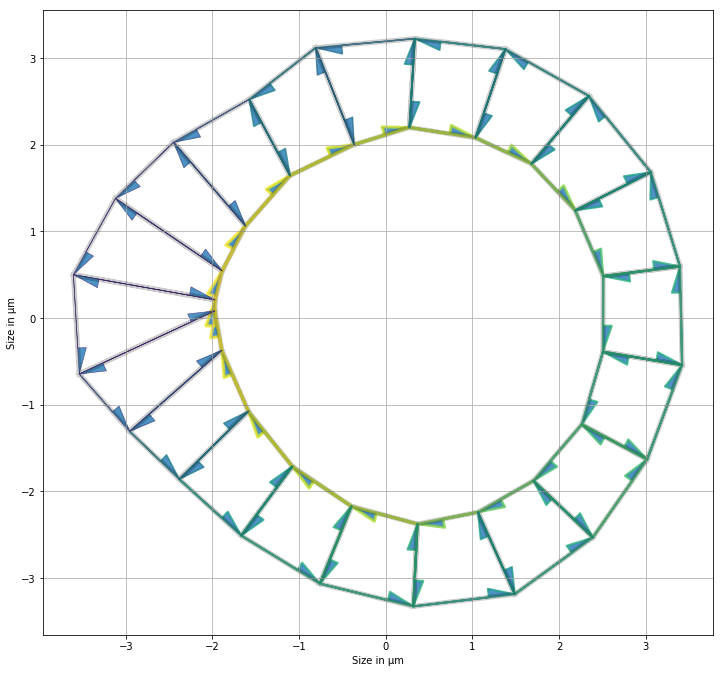

In [89]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [90]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_eq_cst_per_cell.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [91]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.165
2     0.180
3     0.195
4     0.210
5     0.216
6     0.222
7     0.228
8     0.234
9     0.234
10    0.237
11    0.234
12    0.228
13    0.222
14    0.216
15    0.210
16    0.204
17    0.195
18    0.171
19    0.156
20    0.150
21    0.165
22    0.150
23    0.135
24    0.150
25    0.150
26    0.135
27    0.105
28    0.060
29    0.030
      ...  
50    0.030
51    0.042
52    0.063
53    0.108
54    0.087
55    0.123
56    0.117
57    0.129
58    0.138
59    0.153
60    0.165
61    0.150
62    0.132
63    0.153
64    0.153
65    0.138
66    0.102
67    0.057
68    0.027
69    0.030
70    0.042
71    0.063
72    0.108
73    0.087
74    0.123
75    0.117
76    0.129
77    0.138
78    0.153
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.159524
1     0.171626
2     0.153793
3     0.151092
4     0.166324
5     0.158801
6     0.133252
7     0.091433
8     0.053653
9     0.038093
10    0.042930
11    0.057900
12    0.083871
13    0.112560

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [92]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0.04632701 0.04337091 0.05005281 0.05414461 0.05052427 0.05389563
 0.05673603 0.06361809 0.07418817 0.08506454 0.0829797  0.07698936
 0.07046882 0.05795144 0.0676377  0.0529594  0.05834646 0.05269452
 0.04981444 0.04460261] 
Basal tensions:  [0.0419802  0.04025893 0.0401435  0.03768719 0.03543905 0.03617011
 0.03400438 0.0328317  0.03036702 0.03017336 0.02920314 0.02885053
 0.02891583 0.02985957 0.03572802 0.03272145 0.03795121 0.03660682
 0.03935872 0.04034316] 
Lateral tensions:  [0.05120926 0.05589186 0.04934667 0.04770123 0.05354641 0.04945062
 0.04879105 0.04314006 0.03507988 0.0239372  0.02734428 0.03359322
 0.04016894 0.05172576 0.03610307 0.05389884 0.04318728 0.05023351
 0.05034118 0.05458282] 
Area elasticity:  [0.06240191 0.05653352 0.05915331 0.06110675 0.05558379 0.0574829
 0.05287378 0.04754521 0.042019   0.0449474  0.04357329 0.04595562
 0.05184381 0.04486925 0.06092237 0.04832292 0.0595754  0.05620495
 0.0599471  0.0571016 ] 
Lumen area elasticity:  0

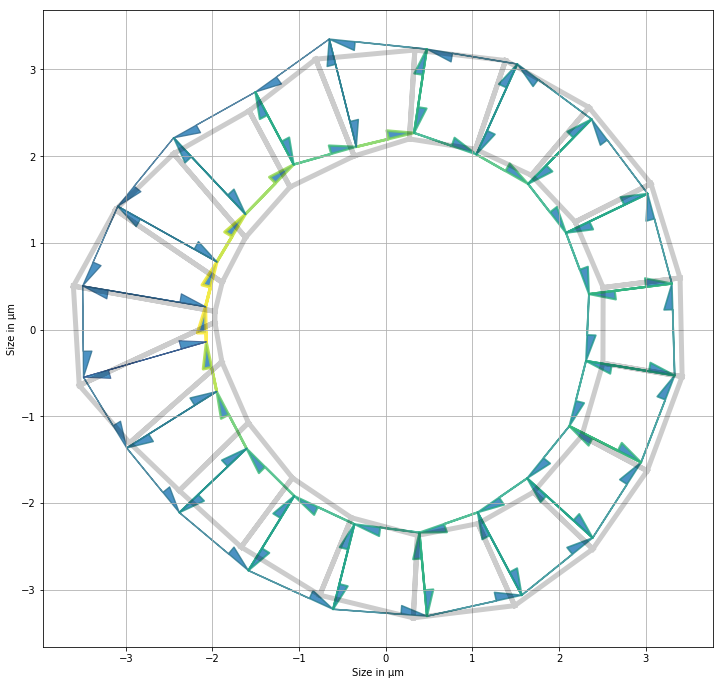

In [93]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*(organo3.edge_df.line_tension.mean() /
               (organo3.face_df.area_elasticity.mean() *
                organo3.face_df.prefered_area.mean()**1.5))]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

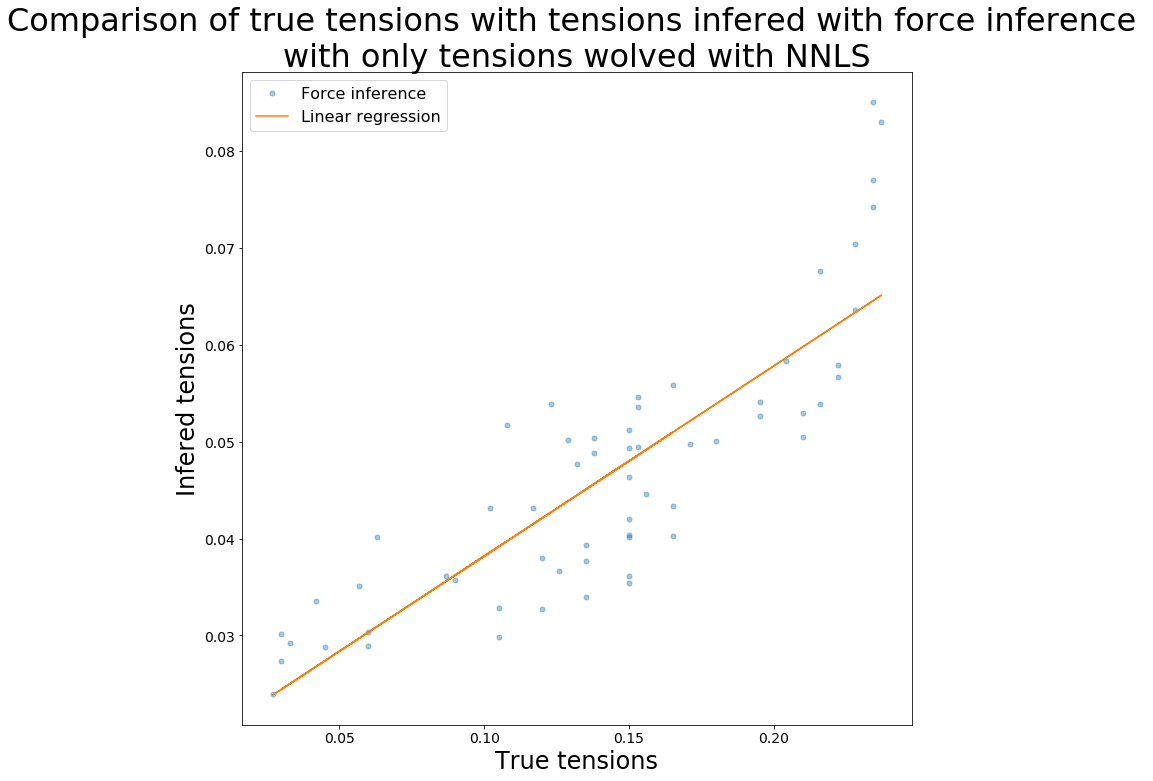

R value : 0.8453265114731467 
Standard error : 0.006319408333395258


In [94]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

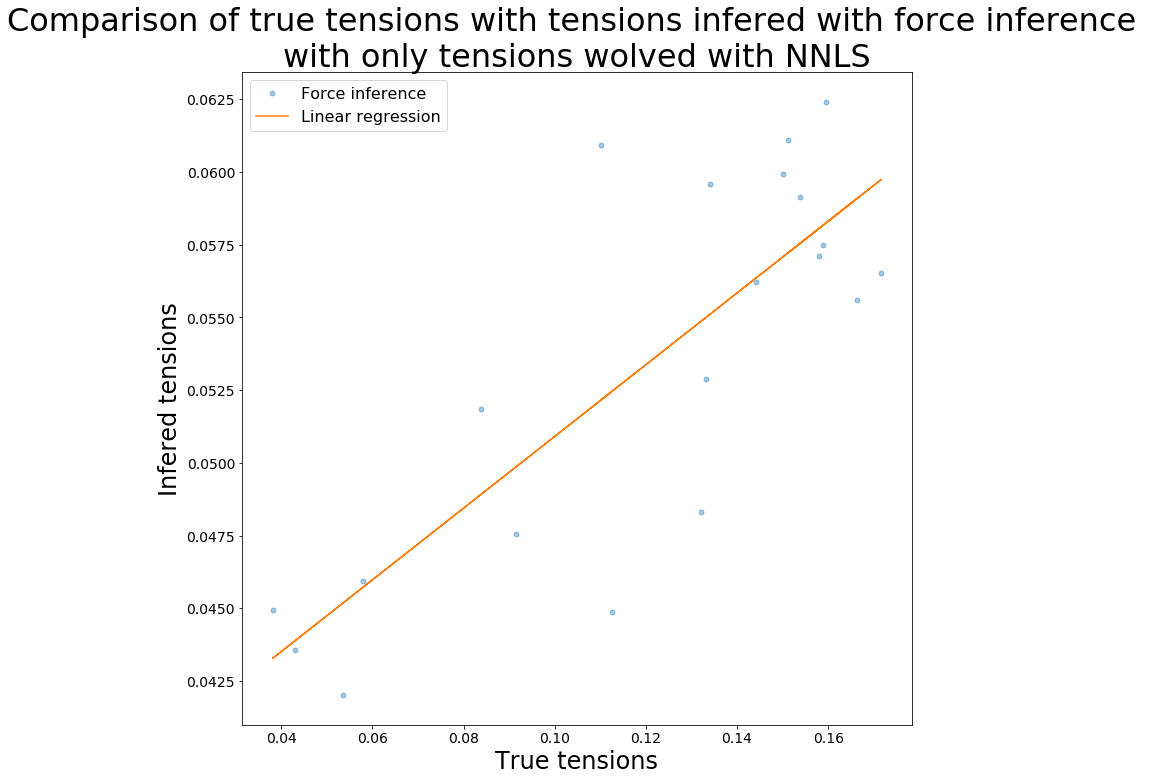

R value : 0.8080129961738685 
Standard error : 0.0019231813869697702


In [95]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_eq_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Minimize the distance wrt tensions and areas

In [96]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

6.5949258994304785 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.594925899663123 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358398
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.594925906807218 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.24553539 0.14610976 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142183 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358398
 0.08984023 0.05998242 0.18749884 0.21831766 0.2771105  0.14101885
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.5949259052390365 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610976 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.594925903679676 [0.19322393 0.17905948 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.24553539 0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.594925821797899 [0.19322393 0.17905947 0.17565468 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.24553539 0.14610975 0.24525268
 0.26298946 0.25385843 0.11227091 0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649056
 0.16960569 0.23417537 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.59492590617702 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610976 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

6.594925905689659 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.5949258989585955 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.08394531
 0.20709001 0.28872766 0.34022613 0.24553539 0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417537 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

6.5949259311028685 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610976 0.2452527
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358398
 0.08984023 0.05998242 0.18749884 0.21831766 0.2771105  0.14101885
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.594925899652986 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.5949258994304785 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.5949258994304785 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.5949258994304785 [0.19322394 0.17905947 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872766 0.34022613 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954656 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101884
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.59492593555127 [0.19322394 0.17905948 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709001 0.28872767 0.34022614 0.2455354  0.14610975 0.24525269
 0.26298946 0.25385843 0.1122709  0.09142182 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.12372949 0.14649056
 0.16960569 0.23417538 0.28371234 0.24954657 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.2771105  0.14101885
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

6.594931618852316 [0.19322411 0.17905961 0.1756549  0.13416893 0.04703821 0.08394533
 0.20709008 0.2887277  0.3402262  0.24553597 0.14611013 0.24525319
 0.26298943 0.25385863 0.11227075 0.0914221  0.06265615 0.10820557
 0.16502781 0.17725589 0.08411371 0.11492194 0.12372953 0.14649062
 0.16960596 0.23417578 0.28371264 0.24954673 0.08259112 0.09358391
 0.08983996 0.05998282 0.187499   0.21831763 0.27711071 0.141019
 0.14912894 0.13597517 0.12212765 0.11173811 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

6.594925389998392 [0.19322392 0.17905947 0.17565467 0.13416873 0.0470381  0.0839453
 0.20709002 0.28872768 0.34022614 0.24553531 0.14610968 0.24525263
 0.26298949 0.25385842 0.11227093 0.09142179 0.06265592 0.10820555
 0.16502762 0.1772557  0.08411362 0.11492187 0.1237295  0.14649057
 0.16960566 0.23417533 0.28371231 0.24954655 0.08259098 0.093584
 0.0898403  0.05998236 0.18749882 0.21831767 0.27711049 0.14101883
 0.1491288  0.13597505 0.12212754 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

6.594925982133493 [0.19322394 0.17905948 0.17565469 0.13416875 0.04703812 0.0839453
 0.20709002 0.28872767 0.34022614 0.2455354  0.14610975 0.2452527
 0.26298947 0.25385844 0.1122709  0.09142183 0.06265595 0.10820555
 0.16502764 0.17725571 0.08411363 0.11492187 0.1237295  0.14649057
 0.16960569 0.23417538 0.28371234 0.24954657 0.08259099 0.09358399
 0.08984024 0.05998242 0.18749884 0.21831766 0.27711051 0.14101885
 0.14912881 0.13597506 0.12212755 0.11173807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

3.284149051045301 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.05572469
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.284149020547481 [0.10204368 0.08733222 0.08628916 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753716 0.11154294 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883377 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757112 0.07029349 0.06778998 0.02577805
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723507 0.05808694
 0.10599302 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

3.284149090231272 [0.10204369 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006586 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111299
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599302 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

3.2841490583520554 [0.10204369 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490596967446 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490639063786 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490564605103 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490470658696 [0.10204368 0.08733222 0.08628917 0.06369847 0.02741557 0.05572469
 0.1121501  0.13006585 0.08753717 0.11154293 0.09894629 0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111299
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723507 0.05808694
 0.10599302 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

3.2841490619656994 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360313 0.07720126 0.14723508 0.05808694
 0.10599302 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490569662373 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599302 0.07787202 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490515914398 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490515914398 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841490515914398 [0.10204368 0.08733222 0.08628917 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.0989463  0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252889 0.09231856 0.04367951 0.06883378 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723508 0.05808694
 0.10599303 0.07787201 0.06433204 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.2841488509552437 [0.10204368 0.08733222 0.08628916 0.06369846 0.02741556 0.05572469
 0.1121501  0.13006584 0.08753716 0.11154293 0.09894628 0.10699969
 0.0986007  0.15320511 0.0402935  0.11128746 0.05216278 0.01912109
 0.08252888 0.09231855 0.04367951 0.06883377 0.05948269 0.07111298
 0.08116009 0.11134815 0.12757112 0.0702935  0.06778997 0.02577804
 0.08487911 0.05264115 0.11360312 0.07720126 0.14723507 0.05808693
 0.10599302 0.07787201 0.06433203 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

3.2841487045104536 [0.10204367 0.08733221 0.08628916 0.06369846 0.02741556 0.05572469
 0.11215009 0.13006583 0.08753715 0.11154292 0.09894627 0.10699969
 0.0986007  0.1532051  0.0402935  0.11128745 0.05216278 0.01912108
 0.08252888 0.09231855 0.04367951 0.06883377 0.05948269 0.07111298
 0.08116009 0.11134815 0.12757112 0.0702935  0.06778996 0.02577804
 0.08487911 0.05264114 0.11360311 0.07720126 0.14723506 0.05808693
 0.10599301 0.07787201 0.06433203 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

3.284147582328867 [0.10204363 0.08733219 0.08628913 0.06369843 0.02741555 0.05572468
 0.11215006 0.13006579 0.08753712 0.11154289 0.0989462  0.10699967
 0.09860065 0.15320506 0.04029349 0.11128743 0.05216276 0.01912106
 0.08252884 0.09231852 0.0436795  0.06883374 0.05948268 0.07111295
 0.08116006 0.11134811 0.12757108 0.07029349 0.06778994 0.02577803
 0.08487909 0.05264111 0.11360307 0.07720125 0.147235   0.05808691
 0.10599296 0.07787199 0.06433201 0.05599147 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.284148980081074 [0.10204368 0.08733222 0.08628916 0.06369846 0.02741556 0.0557247
 0.1121501  0.13006585 0.08753717 0.11154293 0.09894629 0.10699969
 0.09860071 0.15320511 0.04029351 0.11128746 0.05216279 0.01912109
 0.08252888 0.09231856 0.04367951 0.06883377 0.0594827  0.07111298
 0.0811601  0.11134815 0.12757113 0.0702935  0.06778997 0.02577804
 0.08487912 0.05264116 0.11360312 0.07720126 0.14723507 0.05808693
 0.10599302 0.07787201 0.06433203 0.05599149 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.2909029626152755 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.290902960871432 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947903 0.01708991 0.01389883 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.04012011 0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.29090296473994 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447285
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.290902971530916 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.0227397  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.290902959548506 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.290902958884987 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653914 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.290902966658658 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2909029633967988 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291762 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029640270893 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763306
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.290902970938725 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653914 0.05961289 0.0478303  0.03265118 0.0318624  0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447285
 0.02965055 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2909029648675203 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029648675203 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029648675203 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029567935038 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220107 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447285
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029682810442 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863419 0.04012011 0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447284
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029696753187 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389883 0.03763307
 0.03653914 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819065 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320382 0.05977473 0.0424564  0.07447285
 0.02965054 0.02144643 0.01770196 0.02273971 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2909029647370946 [0.00935735 0.01654499 0.04241848 0.03129834 0.01291761 0.01633703
 0.07225029 0.01432972 0.03947904 0.0170899  0.01389882 0.03763307
 0.03653915 0.05961289 0.0478303  0.03265118 0.03186239 0.01298665
 0.0057015  0.02819066 0.02220108 0.0185712  0.00468327 0.02578908
 0.02842892 0.03507525 0.04225279 0.08863418 0.0401201  0.01645349
 0.01513238 0.02318544 0.08320381 0.05977473 0.04245639 0.07447285
 0.02965054 0.02144643 0.01770196 0.0227397  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595224952777 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595285084054 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669291 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595183515828 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595255762722 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595211308819 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175022 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595245391901 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595247877224 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595233796844 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695552 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595284081474 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.0146222  0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595248239291 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595249806677 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595249806677 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595249806677 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595249806677 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595251751473 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595368541037 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.02725919 0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475212 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9004595256184404 [0.00757812 0.0066303  0.02579686 0.00780524 0.01486284 0.01488869
 0.01130441 0.04200128 0.0074504  0.01496399 0.01369482 0.01042254
 0.00663698 0.0298623  0.04330884 0.03530458 0.05901495 0.02679238
 0.0272592  0.00715016 0.00772709 0.00854142 0.03127901 0.03448321
 0.01695551 0.00999143 0.02175023 0.04564247 0.05669292 0.00457634
 0.01462219 0.01926291 0.00475211 0.02983052 0.02492679 0.04998141
 0.05628367 0.0128972  0.03196647 0.00556774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679393664985 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.64006793528151 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.6400679419591544 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.0065805  0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660146 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.640067941284775 [0.00706868 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.00759681 0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6400679435325827 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.640067940289613 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.6400679405148464 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679440615133 [0.00706867 0.0055477  0.01762793 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146928 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679421359037 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679501034843 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679400564817 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679400564817 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679400564817 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679400564817 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679399866872 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679477287924 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022254
 0.0065805  0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.01253011 0.00660146 0.01941714 0.00981806 0.02981923
 0.03908179 0.00940031 0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.6400679437082553 [0.00706867 0.0055477  0.01762792 0.01373958 0.01566479 0.01107718
 0.0077019  0.02235597 0.00694396 0.00317721 0.0050591  0.01022255
 0.00658051 0.01657276 0.02704471 0.02713696 0.04276283 0.02220236
 0.02343697 0.00675514 0.0075968  0.01146929 0.02346672 0.02394387
 0.0137524  0.0079381  0.00717964 0.02870017 0.03375633 0.01439575
 0.01338278 0.0125301  0.00660145 0.01941714 0.00981806 0.02981922
 0.0390818  0.0094003  0.02562755 0.00351166 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.546875531327409 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5468755250603093 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755280821197 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289617 0.00926699 0.01500752 0.01017679
 0.00764208 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.546875531978906 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289617 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5468755327609607 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755285747211 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755326300463 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755296121061 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755296386891 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289617 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.0076229  0.01956385 0.01367459
 0.01747691 0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755321761216 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249728 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755323703981 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755323703981 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755323703981 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755323703981 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.0174769  0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5468755352686147 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148889 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.01105609
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.01747691 0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5468755461837895 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148889 0.02481521
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.01747691 0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.546875544991472 [0.00751635 0.00329989 0.01618618 0.01956115 0.01675031 0.01259531
 0.00960107 0.01161415 0.01289618 0.00926699 0.01500752 0.01017679
 0.00764209 0.00663225 0.01055518 0.00986052 0.04148888 0.02481522
 0.01831149 0.01183447 0.01053705 0.01650889 0.01675903 0.0110561
 0.01005841 0.00806302 0.00552459 0.00762289 0.01956385 0.01367459
 0.01747691 0.00635064 0.00871527 0.01249729 0.00253195 0.02550008
 0.0342346  0.02408135 0.01804397 0.00246309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.4694930545865539 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.46949305402049657 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195511
 0.0072414  0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4694930604320371 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926634 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.46949305661745205 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4694930553276736 [0.00621564 0.00512508 0.015592   0.01845431 0.01691999 0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930558565298 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930548741323 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.46949305427252663 [0.00621564 0.00512509 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.46949305527212215 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.46949305910323513 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541093 0.0098076  0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926634 0.01163833 0.00357779 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4694930529900312 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.0158474  0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930545865539 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930545865539 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930545865539 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4694930594399145 [0.00621564 0.00512508 0.015592   0.01845431 0.01691999 0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738222
 0.02348595 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.46949306351695175 [0.00621564 0.00512508 0.015592   0.01845431 0.01691999 0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878987 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.03089719 0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741692 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926634 0.01163833 0.00357778 0.01738222
 0.02348594 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4694930603470932 [0.00621564 0.00512508 0.015592   0.01845431 0.01692    0.01195512
 0.00724139 0.00814684 0.010835   0.00958091 0.00878986 0.00921704
 0.00572151 0.00541092 0.00980761 0.01512428 0.0308972  0.02045792
 0.01584741 0.01194135 0.00762971 0.01486091 0.01568461 0.00938654
 0.00868554 0.00641919 0.00581783 0.00741691 0.01551931 0.01506563
 0.01359231 0.00572867 0.00926633 0.01163833 0.00357778 0.01738223
 0.02348594 0.01528891 0.01611252 0.00365247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4186164678494634 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4186164683931547 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484264 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.41861647449006767 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633255 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41861646856536816 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41861646840677 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899281 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.41861646621991494 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41861647023597415 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4186164665516848 [0.00480007 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.41861646649849016 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484264 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41861647311738426 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.0098252  0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4186164696966792 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283616 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4186164678494634 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4186164678494634 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4186164678494634 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4186164742687414 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899281 0.01294673
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962723
 0.00804808 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.418616475276576 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899281 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.0093837  0.02075624 0.01551043 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400368 0.00633255 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833999 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.4186164735207042 [0.00480008 0.00597748 0.0146395  0.01625087 0.01899282 0.01294672
 0.00484263 0.00134328 0.01135363 0.00857407 0.00475477 0.00913737
 0.0030724  0.00424862 0.00938371 0.02075624 0.01551044 0.02065604
 0.01495397 0.01283615 0.00618729 0.0135721  0.01625098 0.00962724
 0.00804807 0.00484665 0.00652139 0.00764609 0.01301331 0.0148449
 0.01400367 0.00633254 0.00912923 0.00982521 0.00458817 0.00875369
 0.01833998 0.01218201 0.01401527 0.00585791 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4203130356003244 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130343496343 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295494
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.42031303077408644 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4203130369447055 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391566 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130362713079 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.42031303877568627 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4203130362962155 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130383471226 [0.00653135 0.00750292 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411119 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130357247041 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.00691731 0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.42031303972212186 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4203130298964495 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130356003244 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130356003244 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4203130356003244 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.42031304086897775 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862787
 0.0085765  0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.42031304483698395 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834782 0.0117979  0.01065214
 0.00202218 0.00446091 0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018027
 0.01271527 0.01317146 0.01314333 0.00581345 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.42031304084152227 [0.00653135 0.00750291 0.01386208 0.01827623 0.01888248 0.01295495
 0.00585845 0.00300402 0.00931998 0.00834781 0.0117979  0.01065214
 0.00202218 0.0044609  0.00802991 0.01973581 0.01834012 0.01541339
 0.01540602 0.01391567 0.00731403 0.01411118 0.01521957 0.00862788
 0.00857649 0.0057984  0.0069173  0.00353438 0.0140127  0.01618261
 0.01554799 0.00545171 0.00610541 0.00853333 0.00504196 0.01018028
 0.01271526 0.01317147 0.01314333 0.00581346 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3857792384694478 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.38577923821598215 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38577924196176083 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736872 0.00790994 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3857792394762337 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792390731814 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.38577923833886263 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3857792396048163 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823074
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792393562943 [0.00562577 0.00679637 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792392790479 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447446 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792412920455 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736872 0.00790994 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.385779237037415 [0.00562576 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677001 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3857792384694478 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792384694478 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3857792384694478 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.38577924301241684 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.0076573  0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061532 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38577925117716666 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.0049552  0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467362 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631934
 0.01222952 0.00408522 0.00736872 0.00790995 0.00419362 0.00823075
 0.01123591 0.01061531 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38577924246280015 [0.00562577 0.00679636 0.01427075 0.0173457  0.01876062 0.01261145
 0.00489944 0.00231656 0.01076305 0.0091844  0.00495519 0.00869826
 0.00221256 0.00438261 0.00835602 0.01982044 0.01436318 0.0159224
 0.01309144 0.01369703 0.00635531 0.01290764 0.01467363 0.00806213
 0.00765729 0.0050334  0.00663456 0.00447447 0.0103512  0.01631933
 0.01222952 0.00408522 0.00736871 0.00790995 0.00419362 0.00823075
 0.0112359  0.01061531 0.01259806 0.00677    0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.37283957964602094 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3728395796171302 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.372839577739039 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.002788   0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.37283958031260556 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3728395802104802 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3728395801050638 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3728395811641673 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950975 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.37283958002362816 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261288 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37283958076499857 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3728395822506906 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3728395777370828 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.37283957964602094 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37283957964602094 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37283957964602094 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3728395841166518 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950976 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758068 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3728395940215439 [0.0059922  0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614549 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950975 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.00381591 0.0134303  0.01421289
 0.01078278 0.00509391 0.0070329  0.00712148 0.0035931  0.00782973
 0.01008688 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3728395831864667 [0.00599219 0.0065702  0.01404094 0.01714527 0.01878186 0.0128396
 0.00488015 0.00196958 0.01036867 0.00499411 0.00614548 0.00844109
 0.00278801 0.0048207  0.00880582 0.01950975 0.01206354 0.0144119
 0.01262478 0.01367092 0.00708103 0.01261287 0.0143189  0.00782722
 0.00758067 0.00495683 0.00596858 0.0038159  0.0134303  0.01421288
 0.01078277 0.00509391 0.0070329  0.00712148 0.0035931  0.00782974
 0.01008687 0.00966071 0.01190033 0.00706801 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3819905071935833 [0.00517668 0.00658234 0.01328389 0.01750507 0.01888028 0.01282197
 0.00542196 0.00271383 0.01407132 0.00831065 0.00531439 0.01229749
 0.0030846  0.00705565 0.00878684 0.01883037 0.01261579 0.0132092
 0.01165665 0.01423173 0.00769999 0.01251366 0.01420177 0.00782103
 0.00777878 0.00519431 0.0054048  0.00366693 0.00812852 0.01564556
 0.01281448 0.00566202 0.00859196 0.00554208 0.00429633 0.00915449
 0.00832735 0.00843574 0.01143958 0.00782043 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.36747201948437447 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3674720146428976 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915538
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36747201796496254 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.367472018062381 [0.00566728 0.00682393 0.01357495 0.01726451 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.0075359
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.36747201954230435 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3674720190655868 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36747202141373536 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383928 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36747201997239365 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3674720174799714 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3674720181447441 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01183    0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745284 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.367472018580716 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.367472018580716 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.367472018580716 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3674720233948656 [0.00566728 0.00682393 0.01357495 0.01726451 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3674720553056313 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.0102221  0.01442892
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384141 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3674720303266851 [0.00566728 0.00682393 0.01357495 0.01726452 0.01863795 0.01270864
 0.00513901 0.00217335 0.01232851 0.00674179 0.00472284 0.00915539
 0.00263803 0.00554214 0.00876404 0.01910484 0.01229426 0.01356582
 0.01182999 0.01383929 0.00720638 0.01259013 0.01396343 0.00753591
 0.00744591 0.00501021 0.00555346 0.00389554 0.01022209 0.01442891
 0.01113185 0.00474315 0.00674268 0.00607143 0.00384142 0.00798483
 0.00887075 0.00879048 0.01147406 0.00745285 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3674723409442181 [0.00566729 0.00682395 0.01357496 0.01726453 0.01863797 0.01270866
 0.00513902 0.00217336 0.0123285  0.00674178 0.00472285 0.0091554
 0.00263802 0.00554215 0.00876406 0.01910486 0.01229428 0.01356584
 0.01183001 0.0138393  0.00720637 0.01259012 0.01396343 0.00753591
 0.00744593 0.00501022 0.00555347 0.00389555 0.01022209 0.01442892
 0.01113186 0.00474316 0.00674269 0.00607143 0.00384142 0.00798485
 0.00887075 0.00879049 0.01147407 0.00745284 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3656641787406374 [0.00575659 0.0065891  0.01350046 0.01707133 0.0187548  0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36566418673014417 [0.00575659 0.0065891  0.01350047 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00415    0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3656641775452828 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3656641772556217 [0.00575659 0.0065891  0.01350047 0.01707132 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36566417702942955 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36566417805494245 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36566418088096436 [0.00575659 0.0065891  0.01350047 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3656641800486894 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525442 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36566417742631874 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00415    0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36566417733211465 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3656641778476247 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3656641778476247 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3656641778476247 [0.00575659 0.0065891  0.01350046 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160356 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36566418285740515 [0.00575659 0.0065891  0.01350047 0.01707132 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756533
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00414999 0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3656642131775231 [0.00575659 0.0065891  0.01350047 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.0120953  0.01372256
 0.01160357 0.00415    0.0063622  0.00564249 0.00396289 0.00797675
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36566418942262835 [0.00575659 0.0065891  0.01350047 0.01707133 0.01875481 0.01281956
 0.00525441 0.00230383 0.0102635  0.00584936 0.00761774 0.00887128
 0.00312855 0.00606012 0.00886994 0.01901789 0.01122241 0.01333241
 0.01159905 0.01388985 0.00746583 0.01230499 0.01397105 0.00756532
 0.00739633 0.00508018 0.00528471 0.00332231 0.01209529 0.01372255
 0.01160357 0.00415    0.0063622  0.00564249 0.00396289 0.00797676
 0.0087267  0.0084263  0.0111582  0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36566449707481996 [0.0057566  0.00658911 0.01350048 0.01707134 0.01875483 0.01281958
 0.00525443 0.00230385 0.01026349 0.00584935 0.00761774 0.00887129
 0.00312854 0.00606013 0.00886996 0.01901791 0.01122243 0.01333243
 0.01159907 0.01388986 0.00746582 0.01230499 0.01397105 0.00756533
 0.00739634 0.00508019 0.00528472 0.00332232 0.01209529 0.01372256
 0.01160357 0.00415    0.00636221 0.00564249 0.0039629  0.00797677
 0.0087267  0.00842631 0.01115821 0.00767434 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.35698169648500433 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3569816968025999 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519176 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3569816953637839 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122809 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35698169517499967 [0.00584742 0.00673747 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368068 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169592071305 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169592542495 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169855661654 [0.00584743 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.00747881 0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169753600123 [0.00584742 0.00673746 0.01331602 0.01693552 0.01850928 0.01268814
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511192 0.00339624 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3569816949556649 [0.00584742 0.00673746 0.01331602 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35698169539106056 [0.00584742 0.00673746 0.01331602 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377702 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169572735616 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169572735616 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698169572735616 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850928 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.0129673
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3569816999240123 [0.00584742 0.00673747 0.01331603 0.01693551 0.01850929 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.01296731
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730034
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3569817310637432 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850929 0.01268815
 0.00520994 0.00233179 0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122808 0.01296731
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339624 0.01058379 0.01412697
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3569817072342468 [0.00584742 0.00673746 0.01331603 0.01693552 0.01850929 0.01268815
 0.00520994 0.0023318  0.01103216 0.0063299  0.00519175 0.00871116
 0.00305466 0.00577927 0.0089478  0.01882674 0.01122809 0.01296731
 0.01131058 0.01377701 0.0074788  0.01216299 0.01368067 0.00730033
 0.00718282 0.0049217  0.00511193 0.00339623 0.01058378 0.01412696
 0.0106684  0.00372426 0.00639563 0.00541848 0.00378709 0.00762558
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35698201229490456 [0.00584744 0.00673748 0.01331604 0.01693553 0.01850931 0.01268817
 0.00520996 0.00233181 0.01103215 0.00632989 0.00519176 0.00871117
 0.00305465 0.00577928 0.00894782 0.01882676 0.0112281  0.01296732
 0.01131059 0.01377702 0.00747879 0.01216298 0.01368067 0.00730034
 0.00718283 0.00492171 0.00511193 0.00339624 0.01058378 0.01412697
 0.0106684  0.00372426 0.00639564 0.00541848 0.0037871  0.00762559
 0.00830454 0.00804508 0.01077482 0.0075596  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3530793284789372 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3530793283761372 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307932726218705 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3530793271144151 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356459 0.00718886
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307932770912026 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118453 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3530793277993984 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519374 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307933055446794 [0.00588903 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767067 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3530793294506686 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307932727287394 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550948 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.0101932  0.00398123 0.00595432 0.00519374 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3530793274814954 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371257 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307932765755073 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35307932765755073 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35307932765755073 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715345 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.35307933177442374 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.0120622  0.01356458 0.00718887
 0.00715346 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3530793625875759 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118453 0.00544629 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371257 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715346 0.00485503 0.00487971 0.0032125  0.01108924 0.01333117
 0.0101932  0.00398123 0.00595432 0.00519374 0.00381815 0.00759641
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3530793391104345 [0.00588902 0.00682112 0.01305507 0.01681983 0.01842254 0.01267391
 0.00525678 0.00243935 0.01118452 0.00544628 0.00550949 0.00869434
 0.00323543 0.00592902 0.00902815 0.01862242 0.01111436 0.0126577
 0.01102951 0.01371256 0.00767066 0.01206221 0.01356458 0.00718887
 0.00715346 0.00485503 0.00487971 0.0032125  0.01108923 0.01333116
 0.01019319 0.00398123 0.00595432 0.00519373 0.00381816 0.00759642
 0.00796994 0.00773936 0.01043905 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.35307964342306525 [0.00588904 0.00682113 0.01305508 0.01681985 0.01842256 0.01267393
 0.00525679 0.00243937 0.01118452 0.00544627 0.00550949 0.00869436
 0.00323542 0.00592903 0.00902817 0.01862244 0.01111437 0.01265772
 0.01102952 0.01371257 0.00767065 0.0120622  0.01356458 0.00718887
 0.00715347 0.00485504 0.00487972 0.00321251 0.01108923 0.01333117
 0.0101932  0.00398124 0.00595433 0.00519374 0.00381816 0.00759643
 0.00796994 0.00773937 0.01043906 0.00764513 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743866753255 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743833463784 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539094 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037707 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743818199844 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704286
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743808098707 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743885120984 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743879951553 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908744090621457 [0.00648611 0.00748416 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.33908743995907886 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536819 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480483 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3390874380136877 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.33908743890654164 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3390874385003815 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3390874385003815 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3390874385003815 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.33908743336863295 [0.00648611 0.00748417 0.01266121 0.01597218 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060103 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3390874519936247 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.01089131 0.00581354 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060103 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100625 0.01356075
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704286
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.339087441386816 [0.00648611 0.00748417 0.01266121 0.01597219 0.0173175  0.01220432
 0.00536818 0.00274301 0.0108913  0.00581353 0.00539093 0.00839994
 0.00328152 0.00614282 0.00898595 0.01719255 0.01031561 0.01190512
 0.01032443 0.01331827 0.00699997 0.01060104 0.01205658 0.00630319
 0.00649905 0.00458972 0.00480484 0.00388986 0.01100624 0.01356074
 0.01037708 0.00472679 0.00645798 0.00472579 0.0040509  0.00704287
 0.00681111 0.00650161 0.00908114 0.00680229 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.33908765011554376 [0.00648613 0.00748419 0.01266122 0.0159722  0.01731751 0.01220434
 0.0053682  0.00274303 0.01089129 0.00581352 0.00539094 0.00839995
 0.00328151 0.00614282 0.00898597 0.01719256 0.01031562 0.01190513
 0.01032444 0.01331828 0.00699996 0.01060102 0.01205657 0.00630319
 0.00649906 0.00458973 0.00480484 0.00388987 0.01100624 0.01356075
 0.01037708 0.00472679 0.00645799 0.00472579 0.00405091 0.00704288
 0.0068111  0.00650161 0.00908114 0.00680228 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.25135057824603774 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2513505784336447 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632755 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513505782008142 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513505783462466 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.25135057833896735 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2513505780591122 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513505785805876 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036483 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.25135057828314317 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.25135057836358227 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490672 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.25135057837987684 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.00689351 0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2513505783509823 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513505783509823 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513505783509823 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857534
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632754 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.251350570546754 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857535
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632755 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490672 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2513506030025512 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857535
 0.00581678 0.00378739 0.00931825 0.0047162  0.00632755 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.01178461 0.0133969
 0.00946836 0.00490672 0.00595256 0.0045384  0.00301401 0.00302561
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2513505919867075 [0.01031429 0.01171706 0.01219443 0.01016592 0.00927486 0.00857535
 0.00581678 0.00378739 0.00931824 0.0047162  0.00632755 0.00419874
 0.00110146 0.00604033 0.00707729 0.00901775 0.00819879 0.00777598
 0.0068935  0.01036484 0.00529482 0.00744964 0.008153   0.00205909
 0.00128592 0.0008673  0.00335385 0.00369399 0.0117846  0.01339689
 0.00946836 0.00490671 0.00595256 0.0045384  0.00301402 0.00302562
 0.00267045 0.00194634 0.00275453 0.00285775 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2513508817041649 [0.01031431 0.01171708 0.01219445 0.01016594 0.00927487 0.00857536
 0.0058168  0.0037874  0.00931824 0.00471619 0.00632755 0.00419875
 0.00110147 0.00604034 0.00707731 0.00901776 0.00819881 0.007776
 0.00689352 0.01036485 0.00529481 0.00744963 0.00815299 0.00205908
 0.00128593 0.00086731 0.00335386 0.003694   0.01178461 0.0133969
 0.00946836 0.00490672 0.00595257 0.00453841 0.00301402 0.00302562
 0.00267045 0.00194634 0.00275453 0.00285774 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.24875532159312944 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2487553218757066 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647092 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.24875532153344332 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532182792207 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532160252858 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532199889192 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2487553217658249 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.24875532109830828 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2487553216524209 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.24875532189120386 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532172296352 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532172296352 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875532172296352 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875531220534236 [0.0102421  0.01161693 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587827 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.00738399 0.00800799 0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24875533195911553 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587826 0.00394645 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.00686861 0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.0035001  0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2487553200892014 [0.0102421  0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587827 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703885 0.00895382 0.00812164 0.00771007
 0.0068686  0.01025348 0.00526724 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446991 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282777 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.24875531107029286 [0.01024209 0.01161694 0.01198228 0.01005828 0.00918487 0.00852457
 0.00587827 0.00394646 0.0093246  0.00435875 0.00647093 0.00424177
 0.00126977 0.00611614 0.00703886 0.00895382 0.00812164 0.00771007
 0.00686861 0.01025348 0.00526723 0.007384   0.008008   0.00202371
 0.00128962 0.00087988 0.00329837 0.00350009 0.01156009 0.01295176
 0.00929546 0.00484319 0.00570507 0.00446992 0.00297521 0.00301355
 0.00263329 0.00194796 0.002719   0.00282776 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582745044583 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582771750556 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582738847865 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.244005827676972 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2440058274506365 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.24400582784384117 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582761422185 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582693897388 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582747162664 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582771917914 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.244005827570357 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.244005827570357 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.244005827570357 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797956 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.24400581816513614 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797957 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774057 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400583780955015 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424296 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797957 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.24400582598734855 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797957 0.00758818
 0.00681685 0.01004741 0.00520373 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277248 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2440058170348763 [0.0100977  0.0114139  0.01159465 0.00984863 0.00902069 0.00843881
 0.00599639 0.00424297 0.0093288  0.00379247 0.00670713 0.00433873
 0.00158412 0.00625194 0.00697766 0.00883826 0.00797957 0.00758818
 0.00681685 0.0100474  0.00520372 0.00724204 0.00774058 0.00194527
 0.00129939 0.00090346 0.00319293 0.00314829 0.01112636 0.01218025
 0.00898347 0.00469909 0.00527118 0.00433464 0.0029009  0.00299269
 0.00256109 0.00194795 0.00265519 0.00277247 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23584922256665722 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922280476422 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.00309171 0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358492224974108 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.23584922277691447 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.235849222556408 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.2358492229399374 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.23584922271166084 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922202447742 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922254420138 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922278235063 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584921349962168 [0.00981435 0.01101192 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727065 0.0017735
 0.00132721 0.00094373 0.0029992  0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584923285426368 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930461 0.00309171 0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.0029992  0.00256256 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922116155294 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.0029992  0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407988 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584921237025536 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968534 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.0029992  0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358507061265856 [0.00981325 0.0110099  0.01093258 0.00945924 0.0087451  0.00831761
 0.00621317 0.00476095 0.00930465 0.00309171 0.0070259  0.00455032
 0.0021007  0.00646687 0.00690406 0.00864693 0.0077378  0.00737733
 0.00671163 0.00968612 0.00505281 0.00693347 0.00727136 0.00177348
 0.00132726 0.00094377 0.00299924 0.00256261 0.01034525 0.01097185
 0.0084603  0.00438263 0.00458579 0.00407993 0.00276607 0.00295685
 0.00242502 0.00193715 0.00254651 0.00267354 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23584842879645024 [0.00981443 0.01101199 0.01093221 0.00945676 0.00874414 0.00831808
 0.00621317 0.00476098 0.00930458 0.00309169 0.00702586 0.00455032
 0.00210073 0.00646686 0.00690405 0.00864689 0.00773779 0.00737732
 0.00671165 0.00968541 0.00505289 0.00693338 0.00727139 0.00177289
 0.00132817 0.00094351 0.00299921 0.00256257 0.01034517 0.01097175
 0.00846021 0.00438257 0.00458573 0.00407989 0.00276603 0.00295681
 0.00242501 0.00193712 0.00254647 0.00267275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584896879104758 [0.00981441 0.01101199 0.01093197 0.00945921 0.00874508 0.00831792
 0.00621032 0.00476057 0.00930517 0.00309156 0.00702584 0.00455033
 0.00210071 0.00646685 0.00690405 0.00864691 0.00773778 0.00737732
 0.00671164 0.00968541 0.00505289 0.00693339 0.00727063 0.00177347
 0.00132724 0.00094294 0.00300049 0.0025632  0.01034536 0.01097162
 0.0084602  0.0043826  0.00458575 0.00407989 0.00276603 0.00295682
 0.00242501 0.00193714 0.00254649 0.00267275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584977894611697 [0.00981435 0.01101192 0.0109319  0.00945914 0.00874501 0.00831752
 0.00621312 0.00476102 0.00930412 0.00309514 0.0070229  0.00455059
 0.00210073 0.0064668  0.00690399 0.00864684 0.00773772 0.00737726
 0.00671159 0.00968535 0.0050529  0.00693338 0.00727062 0.0017735
 0.00132721 0.00094373 0.00299917 0.00256246 0.01034451 0.01097153
 0.00846197 0.00438221 0.00458558 0.00407985 0.00276601 0.00295678
 0.00242501 0.00193712 0.00254646 0.00267277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.235849219992374 [0.00981442 0.01101199 0.01093198 0.00945922 0.00874509 0.0083176
 0.00621317 0.00476096 0.00930459 0.00309172 0.007026   0.00455024
 0.00210158 0.00646315 0.00690457 0.00864691 0.00773779 0.00737733
 0.00671165 0.00968542 0.00505289 0.00693338 0.00727062 0.00177347
 0.00132724 0.00094376 0.00299921 0.00256258 0.01034518 0.01097176
 0.00846021 0.00438184 0.00458617 0.00408144 0.00276594 0.00295676
 0.00242501 0.00193714 0.00254648 0.00267275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.23584795225808441 [0.00981443 0.011012   0.01093198 0.00945919 0.00874506 0.00831758
 0.00621316 0.00476097 0.00930459 0.0030917  0.00702586 0.00455032
 0.00210072 0.0064669  0.00690418 0.00864775 0.00773637 0.00737761
 0.00671164 0.0096854  0.00505289 0.00693338 0.00727062 0.00177348
 0.00132722 0.00094374 0.0029992  0.00256256 0.01034518 0.01097175
 0.00846021 0.00438257 0.00458573 0.00407991 0.00276513 0.00295631
 0.00242377 0.00193766 0.00254648 0.00267275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584942125374417 [0.00981495 0.011012   0.010932   0.00945922 0.00874509 0.0083176
 0.00621317 0.00476097 0.00930461 0.0030917  0.00702588 0.00455032
 0.00210072 0.00646686 0.00690406 0.00864691 0.0077378  0.00737772
 0.00671129 0.00968237 0.00505374 0.00693338 0.00727064 0.00177348
 0.00132724 0.00094376 0.00299922 0.00256259 0.0103452  0.01097179
 0.00846025 0.00438259 0.00458575 0.0040799  0.00276604 0.00295682
 0.00242501 0.00193665 0.00254762 0.00267252 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2358503858998401 [0.00981463 0.01101113 0.01093109 0.00945949 0.00874503 0.00831754
 0.00621313 0.00476094 0.00930459 0.00309169 0.00702584 0.00455029
 0.00210069 0.00646682 0.006904   0.00864685 0.00773774 0.00737727
 0.0067116  0.00968535 0.00505308 0.0069354  0.00727051 0.00177373
 0.00132719 0.00094372 0.00299918 0.00256253 0.01034515 0.01097172
 0.00846018 0.00438255 0.0045857  0.00407987 0.00276601 0.00295678
 0.00242502 0.00193712 0.00254645 0.00267277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23585429520360435 [0.00981438 0.01101196 0.01093195 0.00945927 0.00874461 0.00831687
 0.00621352 0.00476092 0.00930463 0.00309171 0.00702586 0.00455029
 0.00210067 0.00646682 0.006904   0.00864687 0.00773774 0.00737728
 0.0067116  0.00968538 0.00505292 0.00693342 0.00727067 0.00177378
 0.00132921 0.0009464  0.0029993  0.00256256 0.0103452  0.01097179
 0.00846025 0.00438259 0.00458574 0.0040799  0.00276603 0.00295681
 0.00242503 0.00193714 0.00254648 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584799674523457 [0.00981438 0.01101195 0.01093193 0.00945913 0.00874498 0.00831751
 0.00621326 0.00476019 0.00930264 0.00309125 0.00702573 0.00455028
 0.00210067 0.0064668  0.00690398 0.00864681 0.00773772 0.00737724
 0.00671157 0.00968534 0.00505292 0.0069334  0.00727065 0.00177352
 0.00132718 0.00094368 0.0029986  0.00256323 0.01034807 0.01097119
 0.00846    0.00438251 0.0045857  0.00407988 0.00276601 0.00295678
 0.00242502 0.00193711 0.00254643 0.00267279 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2358485747485843 [0.00981437 0.01101195 0.01093193 0.00945913 0.00874498 0.0083175
 0.0062131  0.00476092 0.00930453 0.00309177 0.00702399 0.00454904
 0.0021008  0.00646679 0.00690398 0.00864682 0.00773772 0.00737724
 0.00671157 0.00968535 0.00505293 0.00693341 0.00727066 0.00177352
 0.00132719 0.00094371 0.00299917 0.00256253 0.01034509 0.01097164
 0.00846174 0.00438413 0.00458541 0.00407981 0.00276602 0.00295679
 0.00242502 0.00193711 0.00254644 0.00267279 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358528145284966 [0.00981438 0.01101195 0.01093194 0.00945916 0.00874502 0.00831753
 0.00621312 0.00476092 0.00930461 0.0030917  0.00702587 0.00455028
 0.00210118 0.00646545 0.00690294 0.00864687 0.00773774 0.00737726
 0.00671159 0.00968537 0.00505292 0.00693341 0.00727065 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034519 0.01097176
 0.00846022 0.00438247 0.00458526 0.00408382 0.00276819 0.0029565
 0.00242504 0.00193712 0.00254646 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.235850532841406 [0.00981438 0.01101195 0.01093194 0.00945917 0.00874503 0.00831754
 0.00621312 0.00476092 0.00930461 0.0030917  0.00702585 0.00455029
 0.00210068 0.00646682 0.00690401 0.00864723 0.00773711 0.00737679
 0.0067118  0.00968537 0.00505292 0.00693341 0.00727065 0.0017735
 0.00132722 0.00094374 0.0029992  0.00256256 0.01034519 0.01097176
 0.00846022 0.00438258 0.00458573 0.00407989 0.002766   0.00295676
 0.00242208 0.0019414  0.00254666 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.2358497460951221 [0.00981366 0.01101212 0.01093192 0.00945915 0.00874502 0.00831754
 0.00621313 0.00476095 0.00930457 0.00309169 0.00702583 0.0045503
 0.0021007  0.00646682 0.00690401 0.00864684 0.00773774 0.00737727
 0.00671192 0.00968432 0.0050546  0.00693348 0.00727061 0.0017735
 0.00132719 0.00094372 0.00299917 0.00256252 0.01034514 0.0109717
 0.00846016 0.00438254 0.00458569 0.00407986 0.002766   0.00295677
 0.00242501 0.00193711 0.00254609 0.00267338 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.235849961009578 [0.00981413 0.01100953 0.01093933 0.00945696 0.00874473 0.00831723
 0.00621287 0.00476067 0.00930463 0.00309172 0.00702574 0.00455011
 0.00210047 0.0064666  0.00690373 0.00864659 0.00773744 0.00737699
 0.00671132 0.00968508 0.0050531  0.00693096 0.00727739 0.00177186
 0.00132711 0.0009436  0.00299908 0.00256239 0.01034508 0.01097159
 0.00846008 0.00438245 0.00458557 0.00407979 0.0027659  0.00295666
 0.00242508 0.00193711 0.00254639 0.00267291 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584467426165723 [0.00981406 0.01101164 0.01093164 0.00945892 0.00874359 0.00832497
 0.00621072 0.0047606  0.00930466 0.00309172 0.00702577 0.00455009
 0.00210043 0.00646661 0.00690372 0.00864662 0.00773745 0.00737699
 0.00671131 0.0096851  0.00505307 0.00693353 0.00727077 0.00177362
 0.00132816 0.00093839 0.00299893 0.00256249 0.01034513 0.01097167
 0.00846017 0.00438249 0.00458561 0.00407983 0.00276593 0.00295669
 0.0024251  0.00193713 0.00254642 0.00267293 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584771873261573 [0.00981414 0.01101176 0.01093176 0.00945896 0.00874475 0.00831725
 0.00621283 0.00475917 0.00930697 0.00309323 0.0070262  0.00455003
 0.00210039 0.00646665 0.00690374 0.00864666 0.00773749 0.00737701
 0.00671131 0.00968517 0.0050531  0.0069336  0.00727086 0.00177363
 0.00132713 0.00094366 0.00299936 0.0025638  0.01033988 0.01097378
 0.00846087 0.00438256 0.00458572 0.00407993 0.00276601 0.00295677
 0.0024251  0.00193714 0.00254645 0.00267292 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23584744398797625 [0.00981418 0.01101179 0.01093179 0.00945899 0.00874479 0.00831729
 0.0062129  0.00476066 0.00930479 0.00309139 0.00702472 0.00455741
 0.00210012 0.00646671 0.00690377 0.00864668 0.00773753 0.00737705
 0.00671135 0.0096852  0.00505307 0.00693357 0.00727083 0.00177361
 0.00132714 0.00094366 0.00299916 0.00256252 0.01034533 0.010972
 0.00846064 0.00437489 0.0045874  0.00408019 0.00276601 0.00295678
 0.00242509 0.00193713 0.00254644 0.0026729  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358465762986662 [0.00981407 0.01101165 0.01093165 0.00945891 0.00874474 0.00831724
 0.00621285 0.00476061 0.00930468 0.00309172 0.00702578 0.00455009
 0.00210033 0.00646446 0.00691145 0.00864664 0.00773742 0.00737699
 0.0067113  0.00968511 0.00505307 0.00693354 0.00727079 0.00177362
 0.0013271  0.00094363 0.00299912 0.00256245 0.01034515 0.0109717
 0.00846019 0.00438251 0.00458573 0.00407896 0.00276054 0.00295931
 0.002425   0.00193713 0.00254642 0.00267293 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358500323504333 [0.00981408 0.01101166 0.01093166 0.00945892 0.00874477 0.00831726
 0.00621288 0.00476064 0.00930468 0.00309173 0.00702578 0.00455011
 0.00210044 0.00646662 0.00690374 0.00864658 0.00773613 0.00738507
 0.00671018 0.00968515 0.00505305 0.00693353 0.00727077 0.00177361
 0.00132711 0.00094364 0.00299913 0.00256246 0.01034515 0.0109717
 0.00846018 0.00438251 0.00458563 0.00407984 0.00276595 0.00295672
 0.00242486 0.00193761 0.00254556 0.00267292 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584922266815356 [0.00981435 0.01101193 0.01093191 0.00945915 0.00874501 0.00831752
 0.0062131  0.00476089 0.00930462 0.0030917  0.00702585 0.00455028
 0.00210066 0.0064668  0.00690398 0.00864684 0.00773772 0.00737725
 0.00671157 0.00968535 0.00505292 0.00693341 0.00727066 0.0017735
 0.00132721 0.00094373 0.00299919 0.00256255 0.01034518 0.01097176
 0.00846022 0.00438257 0.00458572 0.00407989 0.00276602 0.0029568
 0.00242502 0.00193713 0.00254647 0.00267278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.23584517645141576 [0.00981469 0.01101022 0.0109302  0.00945939 0.00874518 0.00831769
 0.00621324 0.00476102 0.00930462 0.00309169 0.00702593 0.00455037
 0.00210076 0.00646693 0.00690414 0.00864701 0.00773789 0.00737742
 0.00671173 0.0096855  0.00505295 0.00693099 0.00726875 0.00177343
 0.00132732 0.00094383 0.00299928 0.00256268 0.01034526 0.01097189
 0.00846035 0.00438267 0.00458585 0.00407996 0.00276611 0.0029569
 0.00242498 0.00193715 0.00254653 0.00267266 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23585071421213483 [0.00981451 0.01101208 0.01093206 0.00945934 0.00874408 0.00831606
 0.00621325 0.00476103 0.00930459 0.0030917  0.0070259  0.00455038
 0.00210078 0.00646691 0.00690412 0.00864697 0.00773787 0.0073774
 0.00671172 0.00968549 0.00505283 0.00693333 0.00727057 0.00177338
 0.00132825 0.00094439 0.00299921 0.00256264 0.01034522 0.01097182
 0.00846026 0.00438263 0.0045858  0.00407992 0.00276608 0.00295687
 0.00242498 0.00193713 0.0025465  0.00267268 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23585341144033778 [0.00981445 0.01101201 0.01093201 0.00945935 0.00874529 0.00831775
 0.00621321 0.0047594  0.00930322 0.00309225 0.00702607 0.00455042
 0.0021008  0.00646692 0.00690416 0.00864709 0.00773789 0.00737746
 0.00671178 0.00968551 0.00505281 0.00693331 0.00727055 0.00177337
 0.00132738 0.00094391 0.00299975 0.00256417 0.01034503 0.01097262
 0.0084606  0.00438278 0.00458583 0.00407989 0.00276607 0.00295689
 0.00242499 0.0019372  0.00254659 0.00267266 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.23585196856871876 [0.00981437 0.01101194 0.01093194 0.00945929 0.00874522 0.00831768
 0.00621321 0.00476091 0.00930494 0.0030914  0.00702413 0.00454905
 0.00210049 0.00646689 0.00690408 0.00864703 0.00773782 0.00737739
 0.0067117  0.00968544 0.00505286 0.00693336 0.00727059 0.00177341
 0.00132734 0.00094384 0.0029993  0.00256269 0.01034556 0.01097231
 0.00846102 0.00438397 0.00458637 0.00408004 0.00276605 0.00295686
 0.00242502 0.0019372  0.00254658 0.0026727  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2358486121595263 [0.0098145  0.01101207 0.01093206 0.00945932 0.00874522 0.00831771
 0.00621326 0.00476104 0.0093046  0.0030917  0.00702589 0.00455041
 0.00210061 0.00646483 0.00690234 0.00864703 0.00773788 0.00737743
 0.00671175 0.00968551 0.00505282 0.00693333 0.00727057 0.0017734
 0.00132732 0.00094384 0.00299928 0.00256266 0.01034522 0.01097183
 0.00846028 0.00438274 0.00458603 0.00407922 0.00276643 0.00295719
 0.00242495 0.00193716 0.00254654 0.00267267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.2358473821788951 [0.0098145  0.01101208 0.01093206 0.00945928 0.00874515 0.00831766
 0.00621323 0.00476103 0.0093046  0.0030917  0.0070259  0.00455037
 0.00210077 0.00646691 0.00690411 0.00864685 0.00773643 0.00737626
 0.00671172 0.00968548 0.00505284 0.00693335 0.00727059 0.00177343
 0.00132729 0.0009438  0.00299925 0.00256263 0.01034522 0.01097183
 0.00846027 0.00438263 0.0045858  0.00407992 0.0027661  0.00295689
 0.00242471 0.00193565 0.0025464  0.00267268 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.23584485328299104 [0.00981291 0.01101225 0.01093208 0.00945932 0.00874519 0.00831769
 0.00621325 0.00476103 0.0093046  0.0030917  0.00702592 0.00455039
 0.00210077 0.00646693 0.00690414 0.008647   0.00773789 0.00737741
 0.00671186 0.00968331 0.00505061 0.00693344 0.00727058 0.00177341
 0.00132732 0.00094383 0.00299928 0.00256267 0.01034525 0.01097187
 0.00846032 0.00438266 0.00458583 0.00407995 0.00276611 0.0029569
 0.00242498 0.00193715 0.00254652 0.00267053 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

Distance from th organo to exp organo : 0.37606101842084017
Distance from th tensions to exp tensions : 0.8054438341622112


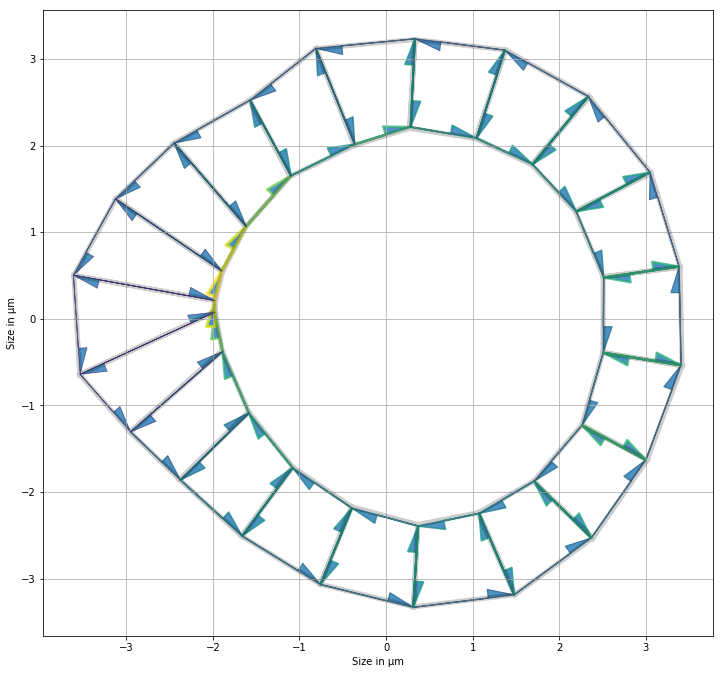

In [97]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

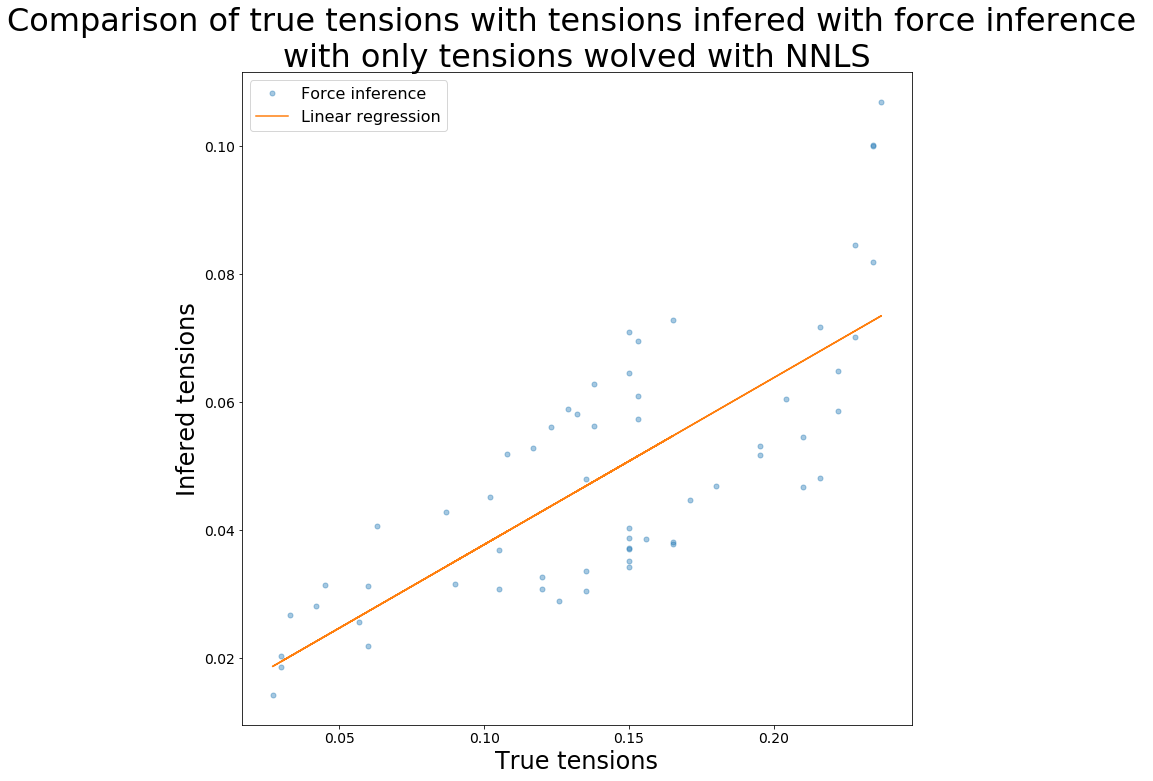

R value : 0.7605783541660588 
Standard error : 0.011329116866357564


In [98]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

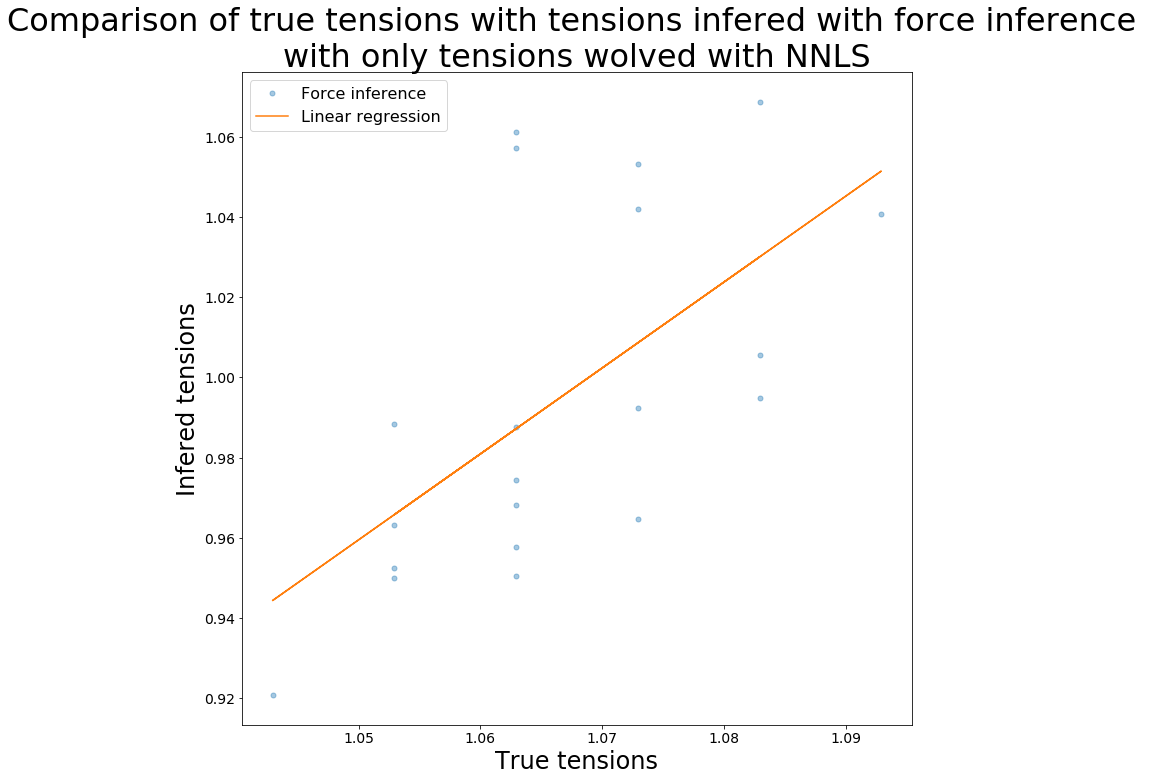

R value : 0.6122089966465875 
Standard error : 0.017103565062153533


In [99]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))